<a href="" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Modal Retrieval using BGE text embedding and CLIP image embedding for Wikipedia Articles

In this notebook, we show how to build a Multi-Modal retrieval system using LlamaIndex.

Wikipedia Text embedding index: BAAI/bge-small-en-v1.5 for texts

Wikipedia Images embedding index: [CLIP](sentence-transformers/clip-ViT-B-32-multilingual-v1) embeddings from sentence transformer for images


Query encoder:
* Encoder query text for text index using HF embedding
* Encoder query text for image index using CLIP embedding

Framework: [LlamaIndex](https://github.com/run-llama/llama_index)

Steps:
1. Download texts and images raw files for Wikipedia articles
2. Build text index for vector store using BGE embeddings
3. Build image index for vector store using CLIP embeddings
4. Retrieve relevant text and image simultaneously using different query encoding embeddings and vector stores

In [ ]:
%pip install llama_index ftfy regex tqdm
%pip install llama-index-vector-stores-qdrant llama-index-embeddings-clip
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install -U qdrant_client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 697.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.3/229.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-xuakd2ty
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-xuakd2ty
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369499 sha256=608cde2ff6122f16039aa8d1414788a1cff5fdc0b300c27b43fe97fda9047022
  Stored in directory: /tmp/pip-ephem-wheel-cache-73asrjj_/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 14.2 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: pillow 10.3.0
    Uninstalling pillow-10.3.0:
      Successfully uninstalled pillow-10.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of

## Load and Download Multi-Modal datasets including texts and images from Wikipedia
Parse wikipedia articles and save into local folder

In [ ]:
from pathlib import Path
import requests

wiki_titles = [
    "batman",
    "Pablo Picasso",
    "France",
    "Tesla Model S",
    "BTS",
]


data_path = Path("data_wiki")

for title in wiki_titles:
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "extracts",
            "explaintext": True,
        },
    ).json()
    page = next(iter(response["query"]["pages"].values()))
    wiki_text = page["extract"]

    if not data_path.exists():
        Path.mkdir(data_path)

    with open(data_path / f"{title}.txt", "w") as fp:
        fp.write(wiki_text)

In [ ]:
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11680 sha256=526bc561dd1ada16c1517ce720aae9121bc11d48070bdb8fe98bd965d5796f2b
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


## Parse Wikipedia Images and texts. Load into local folder

In [ ]:
import wikipedia
import urllib.request

image_path = Path("data_wiki")
image_uuid = 0
# image_metadata_dict stores images metadata including image uuid, filename and path
image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 60

wiki_titles = [
    "batman",
    "Pablo Picasso",

    "Tesla Model S",
    "BTS",
]

# create folder for images only
if not image_path.exists():
    Path.mkdir(image_path)


# Download images for wiki pages
# Assing UUID for each image
for title in wiki_titles:
    images_per_wiki = 0
    print(title)
    try:
        page_py = wikipedia.page(title)
        list_img_urls = page_py.images
        for url in list_img_urls:
            if url.endswith(".jpg") or url.endswith(".png"):
                image_uuid += 1
                image_file_name = title + "_" + url.split("/")[-1]

                # img_path could be  path pointing to the raw image file in the future
                image_metadata_dict[image_uuid] = {
                    "filename": image_file_name,
                    "img_path": "./" + str(image_path / f"{image_uuid}.jpg"),
                }
                urllib.request.urlretrieve(
                    url, image_path / f"{image_uuid}.jpg"
                )
                images_per_wiki += 1
                # Limit the number of images downloaded per wiki page to 15
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except:
        print(str(Exception("No images found for Wikipedia page: ")) + title)
        continue

batman
Pablo Picasso
No images found for Wikipedia page: Pablo Picasso
Tesla Model S
No images found for Wikipedia page: Tesla Model S
BTS
No images found for Wikipedia page: BTS


## Build Multi Modal Vector Store using Text and Image embeddings under different collections

In [ ]:
!pip install llama_index.embeddings.huggingface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 853.2/853.2 kB 10.5 MB/s eta 0:00:00


In [ ]:
import qdrant_client
from llama_index.core import SimpleDirectoryReader
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core import Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

embed_model_text = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")
embed_model_image = HuggingFaceEmbedding(model_name="sentence-transformers/clip-ViT-B-32-multilingual-v1")
Settings.embed_model = embed_model_image
Settings.chunk_size = 512

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_db_test")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection", embed_model=embed_model_text
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection", embed_model=embed_model_image
)
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# Create the MultiModal index
documents = SimpleDirectoryReader("./data_wiki/").load_data()
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (101972528 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  


### Plot downloaded Images from Wikipedia

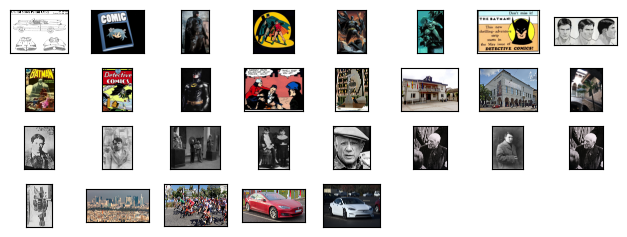

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os


def plot_images(image_metadata_dict):
    original_images_urls = []
    images_shown = 0
    for image_id in image_metadata_dict:
        img_path = image_metadata_dict[image_id]["img_path"]
        if os.path.isfile(img_path):
            filename = image_metadata_dict[image_id]["filename"]
            image = Image.open(img_path).convert("RGB")

            plt.subplot(8, 8, len(original_images_urls) + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            original_images_urls.append(filename)
            images_shown += 1
            if images_shown >= 64:
                break

    plt.tight_layout()


plot_images(image_metadata_dict)

### Build a separate CLIP image embedding index under a differnt collection `wikipedia_img`

In [ ]:
def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

## Get Multi-Modal retrieval results for some example queries

In [ ]:
test_query = "who are BTS team members"
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=2)
retrieval_results = retriever.retrieve(test_query)

**Node ID:** c3602aef-fc13-4d20-a110-ccf796083a12<br>**Similarity:** 0.7472104374432007<br>**Text:** === Philanthropy ===

BTS are known for their philanthropic endeavors. Several members of the band have been inducted into prestigious donation clubs, such as the UNICEF Honors Club and the Green N...<br>

**Node ID:** b9834486-3191-42c8-a859-fd4350e000c5<br>**Similarity:** 0.7265361912295911<br>**Text:** The group's accolades include multiple American Music Awards, Billboard Music Awards, Golden Disc Awards, and nominations for five Grammy Awards. Outside of music, they have addressed three session...<br>

**Node ID:** 4dcc8072-685b-4b71-a800-e90023e26905<br>**Similarity:** 0.7197161367724461<br>**Text:** BTS (Korean: 방탄소년단; RR: Bangtan Sonyeondan; lit. Bulletproof Boy Scouts), also known as the Bangtan Boys, is a South Korean boy band formed in 2010. The band consists of Jin, Suga, J-Hope, RM, Jimi...<br>

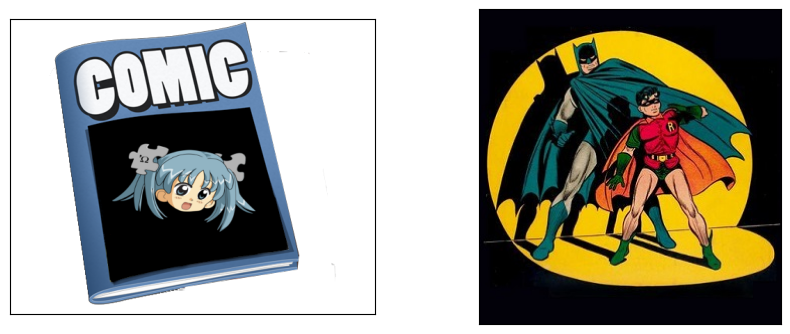

In [ ]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

**Node ID:** 4806b274-9723-4c43-b867-9dc122831c87<br>**Similarity:** 0.815937161956291<br>**Text:** Pablo Ruiz Picasso (25 October 1881 – 8 April 1973) was a Spanish painter, sculptor, printmaker, ceramicist, and theatre designer who spent most of his adult life in France. One of the most influen...<br>

**Node ID:** 8edce474-e887-405d-9ddb-ee9597b0f0b6<br>**Similarity:** 0.8000044580246515<br>**Text:** == Style and technique ==

Picasso was exceptionally prolific throughout his long lifetime. At his death there were more than 45,000 unsold works in his estate, comprising 1,885 paintings, 1,228 sc...<br>

**Node ID:** 13645a89-2ed7-4f29-96e6-83f97792877d<br>**Similarity:** 0.790019967359648<br>**Text:** Prominent in his Cubist paintings are forms easily recognized as guitars, violins, and bottles. When Picasso depicted complex narrative scenes it was usually in prints, drawings, and small-scale wo...<br>

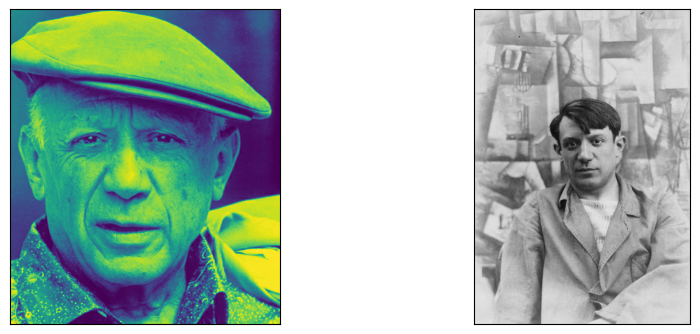

In [ ]:
test_query = "what are Pablo Picasso's famous paintings"
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=2)
retrieval_results = retriever.retrieve(test_query)

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

**Node ID:** b1667973-52fb-4652-87a1-3bd194e0c5e1<br>**Similarity:** 0.8325665001122345<br>**Text:** === Tourism ===

With 89 million international tourist arrivals in 2018, France is the world's top tourist destination, ahead of Spain (83 million) and the United States (80 million). However, it r...<br>

**Node ID:** 309a3f82-066e-4adb-b7df-585882bfb1a9<br>**Similarity:** 0.8162136655299929<br>**Text:** Disneyland Paris is Europe's most popular theme park, with 15 million combined visitors to the resort's Disneyland Park and Walt Disney Studios Park in 2009.
With more than 10 million tourists a ye...<br>

**Node ID:** cec3c203-3110-45f2-8d1b-69cc5a5512e5<br>**Similarity:** 0.728273289458136<br>**Text:** The Château de Chantilly, Versailles and Vaux-le-Vicomte, all three located near Paris, are also visitor attractions.
France has 52 sites inscribed in UNESCO's World Heritage List and features citi...<br>

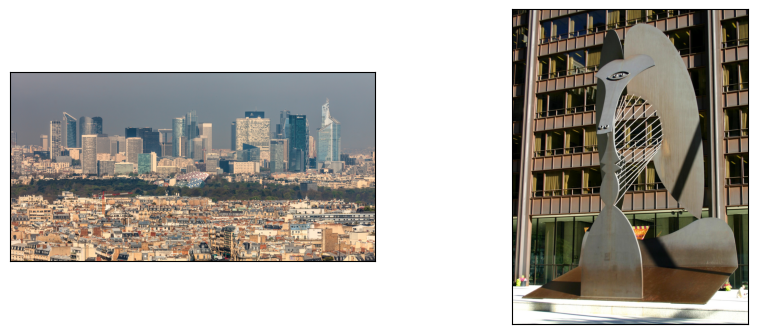

In [ ]:
test_query = "what is the popular tourist attraction in France"
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=2)
retrieval_results = retriever.retrieve(test_query)

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

**Node ID:** 9ab6662e-3259-41c3-bf23-a31551d258a3<br>**Similarity:** 0.8596872767476748<br>**Text:** === Energy consumption ===
Under its five-cycle testing protocol, the United States Environmental Protection Agency (EPA) rated the 90 kWh version at a combined fuel economy equivalent of 104 MPGe ...<br>

**Node ID:** d4056325-f521-4f7b-91ba-8376efeda2a9<br>**Similarity:** 0.8579765750200515<br>**Text:** == Sales and markets ==

U.S. deliveries began June 2012. Tesla reported 520 reservations for the Model S during the first week they were available and by December 2012, a total 15,000 net reservat...<br>

**Node ID:** 35dbac51-c773-4af9-a492-f096344e1e68<br>**Similarity:** 0.8579741392356874<br>**Text:** === Records ===
All of these records used hypermiling techniques such as front motor only, low speed 24 mph (39 km/h), no air conditioning and minimal use of the brakes.  These attempts were inspir...<br>

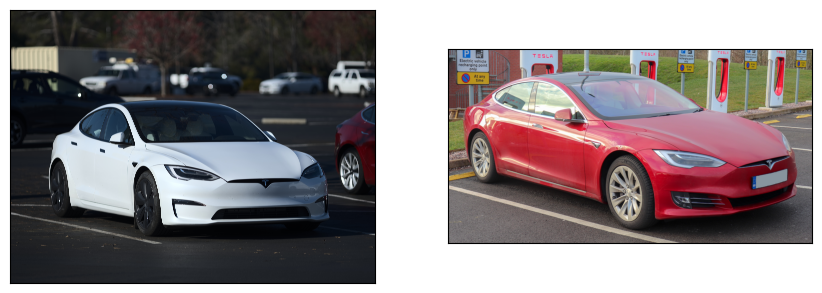

In [ ]:
test_query = "which company makes Tesla"
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=2)
retrieval_results = retriever.retrieve(test_query)

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

**Node ID:** 09a5f0f9-0aa8-4596-a529-f6209f3c0a51<br>**Similarity:** 0.9082178250886794<br>**Text:** == Supporting characters ==

Batman's interactions with both villains and cohorts have, over time, developed a strong supporting cast of characters.


=== Enemies ===

Batman faces a variety of foe...<br>

**Node ID:** 4f0ad7e1-3865-4585-8a15-04af8cc02ecd<br>**Similarity:** 0.8927949441475387<br>**Text:** ==== Batom ====
Batom is a Batman from an unknown part of the Dark Multiverse who sports the same Bio-Belt as Atom.


==== Batmobeast ====
Batmobeast is a version of Batman from an unknown part of ...<br>

**Node ID:** 6aa4b57b-5410-48de-972b-6d6c12756513<br>**Similarity:** 0.8927949441475387<br>**Text:** ==== Batom ====
Batom is a Batman from an unknown part of the Dark Multiverse who sports the same Bio-Belt as Atom.


==== Batmobeast ====
Batmobeast is a version of Batman from an unknown part of ...<br>

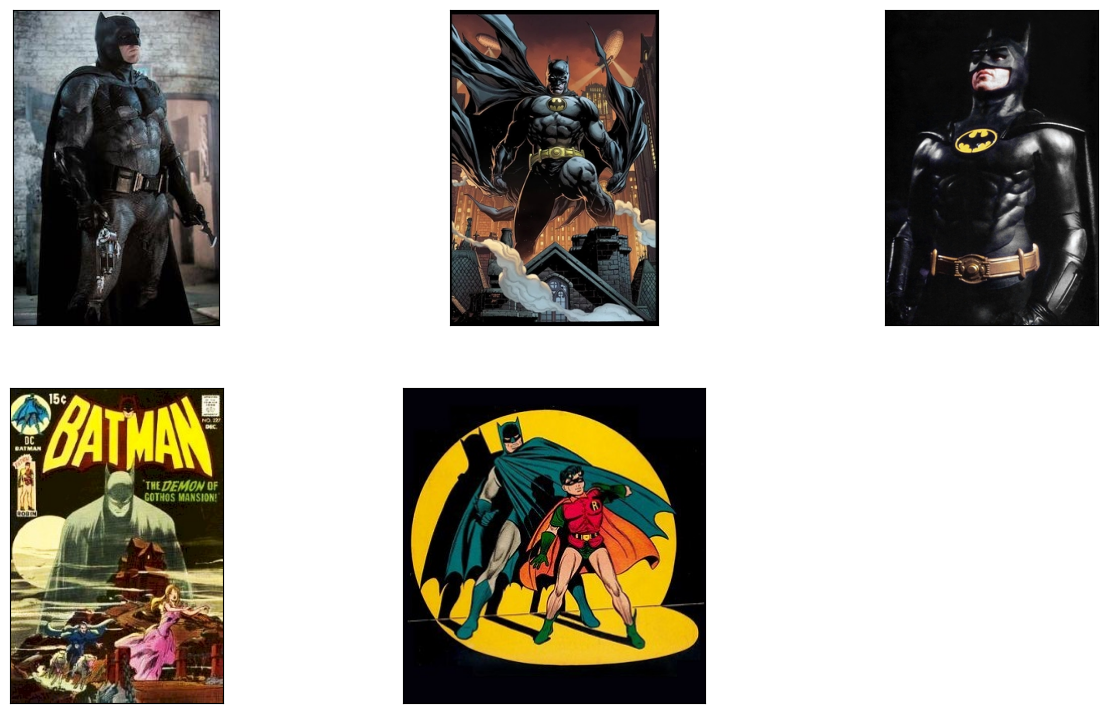

In [ ]:
test_query = "what is the main character in Batman"
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=5)
retrieval_results = retriever.retrieve(test_query)

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)